In [69]:
import pandas as pd
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sns


In [70]:
# Chargement du fichier CSV contenant les chemins vers les images et leurs catégories
df = pd.read_csv('dataset_chiffre_r.csv')


In [71]:
# affichage chemin des images et catégories
df

,images,category
0,dataset_chiffre/0/img001-00001.png,0
1,dataset_chiffre/0/img001-00002.png,0
2,dataset_chiffre/0/img001-00003.png,0
3,dataset_chiffre/0/img001-00004.png,0
4,dataset_chiffre/0/img001-00005.png,0
...,...,...
10155,dataset_chiffre/9/img010-01012.png,9
10156,dataset_chiffre/9/img010-01013.png,9
10157,dataset_chiffre/9/img010-01014.png,9
10158,dataset_chiffre/9/img010-01015.png,9


In [72]:
# Colonne contenant les labels (0 à 9, sous forme de texte)
df['category']

0        0
1        0
2        0
3        0
4        0
        ..
10155    9
10156    9
10157    9
10158    9
10159    9
Name: category, Length: 10160, dtype: int64

In [73]:
# Initialise un encodeur pour transformer les catégories textuelles en entiers
le = preprocessing.LabelEncoder()
# Apprentissage des classes disponibles (0 à 9)
le.fit(df['category'])
# Conversion des labels texte en labels numériques
y = le.transform(df['category'])
 # Affiche la forme du tableau de labels
print(y.shape)
# Vérifie la correspondance entre entiers et labels
print(list(le.inverse_transform([0, 1, 2])))


(10160,)
[np.int64(0), np.int64(1), np.int64(2)]


In [74]:
#contient les images chargées
X = []
index = 0
 # Parcourt chaque chemin d'image
for files in df.images: 
    # Charge et convertit en RGB
    X.append(cv2.cvtColor(cv2.imread(files), cv2.COLOR_BGR2RGB))
    index = index+1
# Convertit la liste en tableau numpy
X = np.asarray(X)
# Affiche la forme : (nb_images, hauteur, largeur, canaux)
print(X.shape)

(10160, 128, 128, 3)


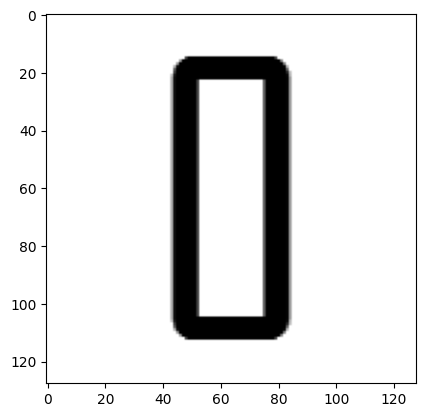

In [75]:
 # Affiche la première image
plt.imshow(X[0])


In [76]:
# Sépare les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6807, 128, 128, 3)
(6807,)
(3353, 128, 128, 3)
(3353,)


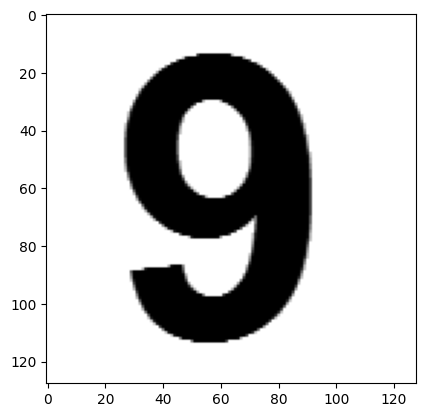

In [77]:
# Affiche la dixième image de l'ensemble d'entraînement
plt.imshow(X_train[10])

In [78]:
#initialise le modèle séquentiel de Keras
model = keras.models.Sequential()
# 8 filtres de 3x3, activation ReLU (intro non linéarité), définir entrée de forme (128, 128, 3)
model.add(keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(128,128,3)))
# Réduction de dimensionnement par max pooling (2x2 pixels)
# Accélère le calcul et rend le modèle plus robuste aux petites variations.
model.add(keras.layers.MaxPooling2D((2,2)))
# désactive aléatoirement 20 % des neurones pendant l'entraînement pour éviter l'overfitting
model.add(keras.layers.Dropout(0.2))

# Même chose que précédemment, mais avec 16 filtres
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.2))

# Méme chose que précédemment, mais avec 32 filtres et une couche de dropout de 30 %
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.3))

# Transforme les données 2D en 1D pour la couche dense
model.add(keras.layers.Flatten())
# Couche dense avec 100 neurones. Relie chaque neurone précédent à chaque neurone actuel.
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.1))

# J'ai eliminé la couche précédente car je n'obtenait des mauvais résultats avec
# model.add(keras.layers.Dense(400, activation='relu'))
# model.add(keras.layers.Dropout(0.2))

# Couche de sortie avec 10 neurones (une pour chaque chiffre de 0 à 9) et activation softmax pour la classification multi-classe
model.add(keras.layers.Dense(10, activation='softmax'))  # 10 classes pour chiffres


c:\Users\Clément\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\Documents\Année M1\Système intelligent\r-solution-de-sudoku\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
# Affiche l'architecture du modèle
model.summary()

model.compile(optimizer='adam', # Optimiseur Adam pour la descente de gradient
              loss='sparse_categorical_crossentropy', # la fonction de perte pour la classification multi-classes
              metrics=['accuracy']) # la métrique pour évaluer le modèle

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,342 (2.42 MB)

 Trainable params: 634,342 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# Entraînement du modèle
batch_size  = 64
epochs      =  16
history = model.fit(  X_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data=(X_test, y_test))

Epoch 1/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.2124 - loss: 92.3994 - val_accuracy: 0.8276 - val_loss: 0.6139
Epoch 2/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7595 - loss: 0.8428 - val_accuracy: 0.9105 - val_loss: 0.3080
Epoch 3/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.8470 - loss: 0.5259 - val_accuracy: 0.9168 - val_loss: 0.2690
Epoch 4/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8772 - loss: 0.4203 - val_accuracy: 0.9401 - val_loss: 0.1998
Epoch 5/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9032 - loss: 0.3079 - val_accuracy: 0.9508 - val_loss: 0.1789
Epoch 6/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.9217 - loss: 0.2595 - val_accuracy: 0.9565 - val_loss: 0.1490
Epoch 7/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9307 - loss: 0.2288 - val_accuracy: 0.9571 - val_loss: 0.1495
Epoch 8/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.9407 - loss: 0.1

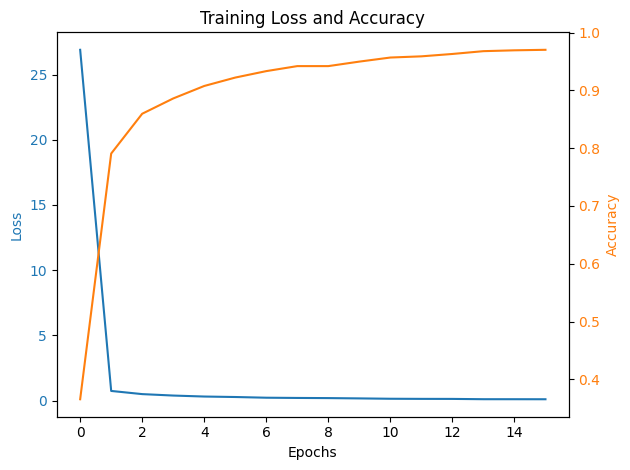

In [81]:
# Affiche la courbe de perte (loss) et d’exactitude (accuracy)
fig, ax1 = plt.subplots()   
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(history.history['loss'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(history.history['accuracy'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

In [82]:
# Évaluation du modèle sur l'ensemble de test
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0654
Test accuracy : 0.9788


In [83]:
# Prédictions sur l'ensemble de test
y_sigmoid = model.predict(X_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


              precision    recall  f1-score   support

           0     0.9888    0.9888    0.9888       356
           1     0.9739    0.9545    0.9641       352
           2     0.9819    0.9819    0.9819       332
           3     0.9732    0.9879    0.9805       331
           4     0.9767    0.9941    0.9853       338
           5     0.9875    0.9694    0.9784       327
           6     0.9788    0.9818    0.9803       329
           7     0.9683    0.9853    0.9767       341
           8     0.9816    0.9726    0.9771       329
           9     0.9778    0.9717    0.9748       318

    accuracy                         0.9788      3353
   macro avg     0.9789    0.9788    0.9788      3353
weighted avg     0.9789    0.9788    0.9788      3353



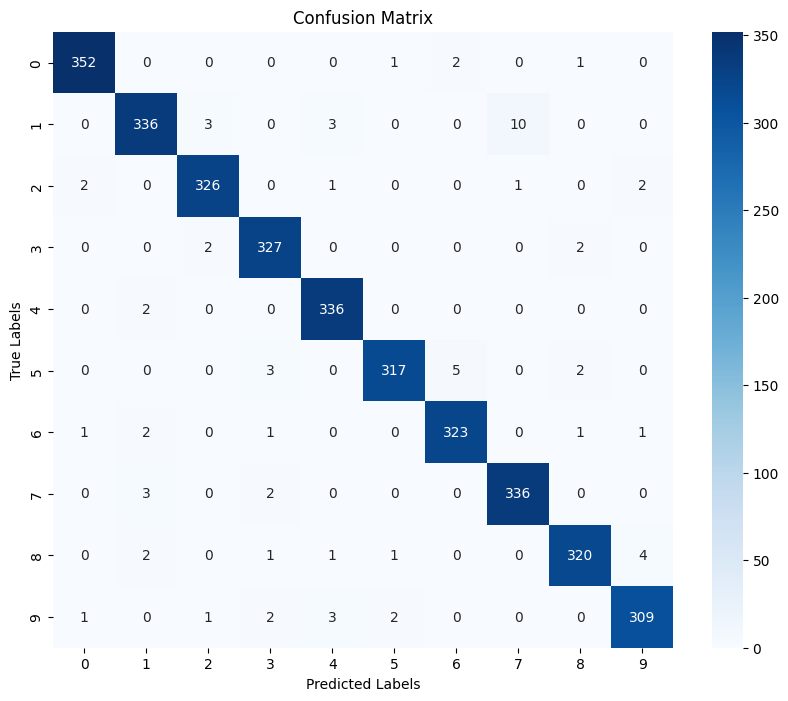

In [84]:
print(classification_report(y_test, y_pred, digits=4))
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [85]:
# Sauvegarde du modèle
model_path = "c:/Image_save/model14.keras"  
tf.keras.models.save_model(
    model,
    filepath = model_path,
    overwrite=True,
)
# Chargement du modèle sauvegardé pour une utilisation ultérieure
model2 = keras.models.load_model(model_path)


In [86]:
# Indices des erreurs
errors = [i for i in range(len(X_test)) if y_pred[i] != y_test[i]]
print(f"Nombre d'erreurs : {len(errors)} / {len(X_test)}")


Nombre d'erreurs : 71 / 3353


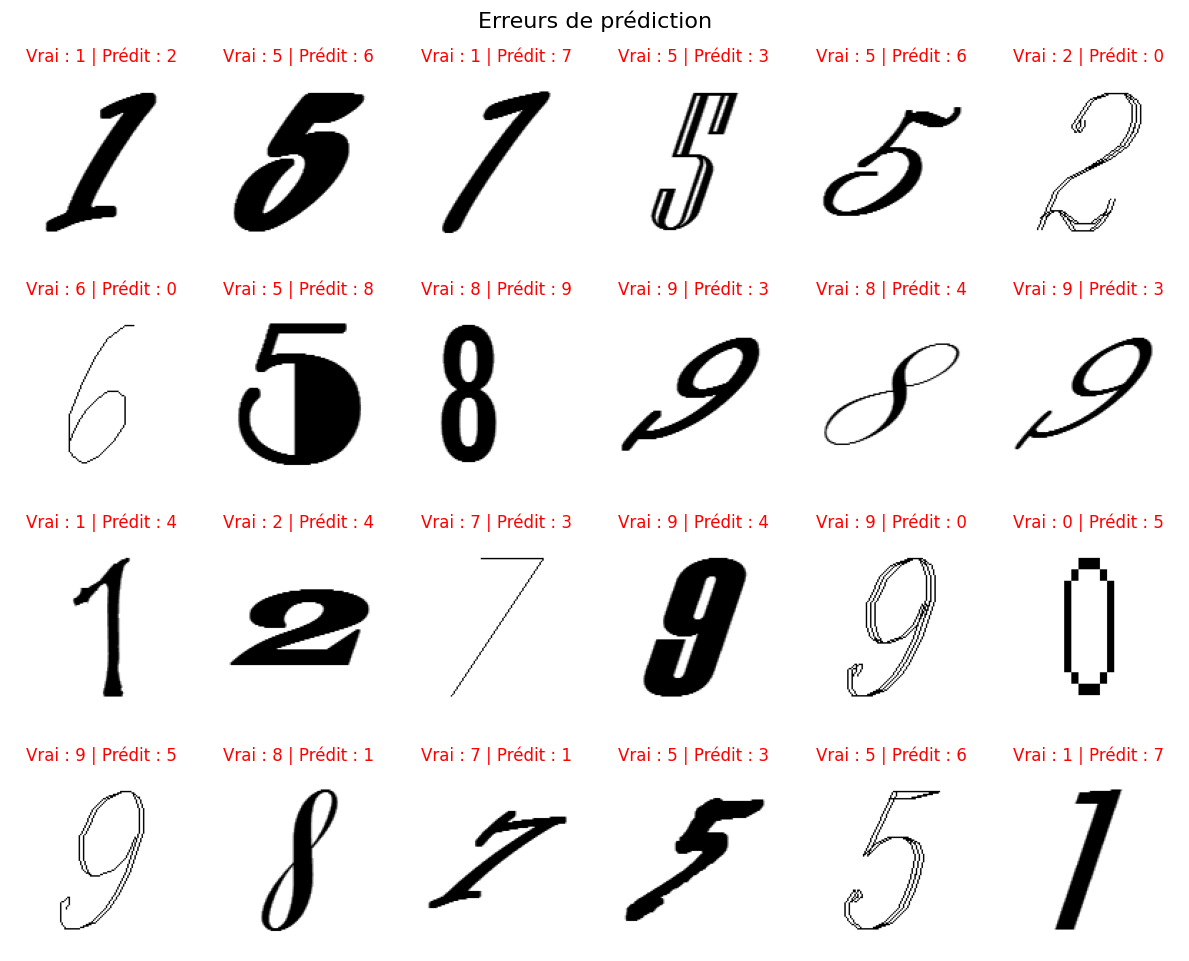

In [87]:
# Affichage des premières erreurs
plt.figure(figsize=(12, 10))
for i, idx in enumerate(errors[:24]):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai : {y_test[idx]} | Prédit : {y_pred[idx]}", color='red')
    plt.axis('off')
plt.suptitle("Erreurs de prédiction", fontsize=16)
plt.tight_layout()
plt.show()


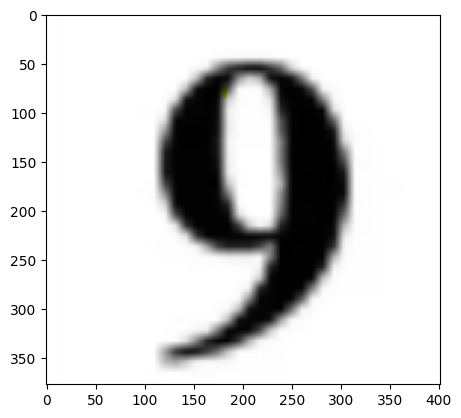

In [107]:
# Affichage d'une nouvelle image
NewData1 = cv2.cvtColor(cv2.imread('6.png'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData1)

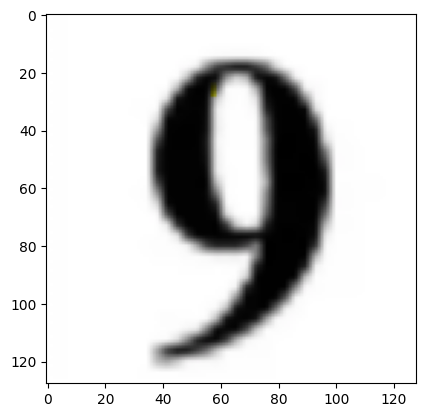

In [108]:
# Redimensionne au format du modèle
NewData1 = cv2.resize(NewData1,(128,128)) 
plt.imshow(NewData1)

In [109]:
input_img = np.expand_dims(NewData1, axis=0)
y_sigmoid = model2.predict(input_img)
y_pred    = np.argmax(y_sigmoid, axis=-1)
# Affiche le chiffre prédit
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[9]
